# Testing out some distributions in Tensorflow Probability

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
sns.reset_defaults()
sns.set_context(context='talk',font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Univariate normal

In [28]:
uv_normal = tfd.Normal(loc=0., scale=1.)

In [29]:
uv_normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [32]:
samples = uv_normal.sample(1000)

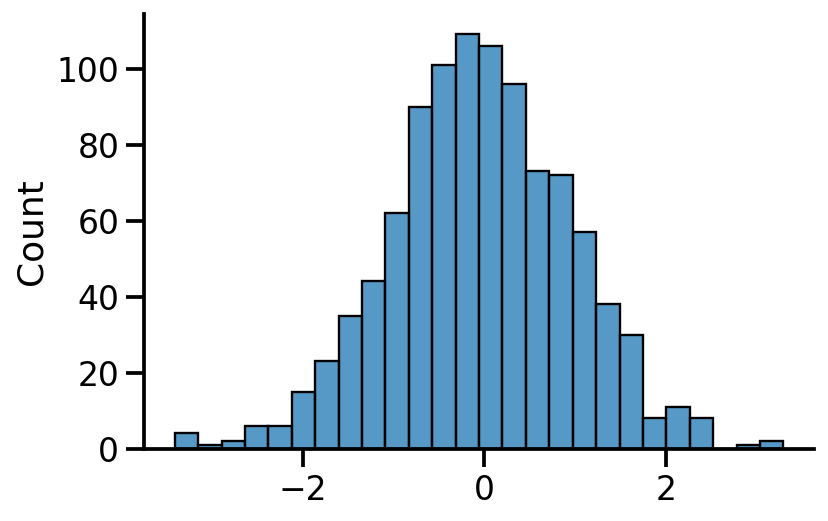

In [33]:
sns.histplot(samples.numpy())
sns.despine()

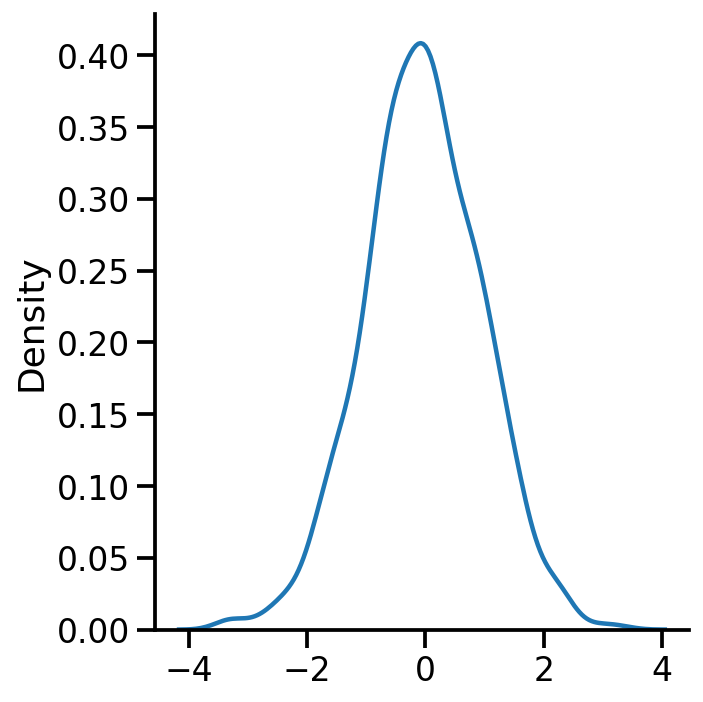

In [37]:
sns.displot(samples.numpy(), kind='kde')

In [60]:
uv_normal_dict_mean = {x: tfd.Normal(loc=x, scale=1.) for x in [-2, -1, 0, 1, 2]}

In [61]:
uv_normal_dict_mean_samples = pd.DataFrame({x:uv_normal_dict_mean[x].sample(10000).numpy() 
                                            for x in uv_normal_dict_mean})

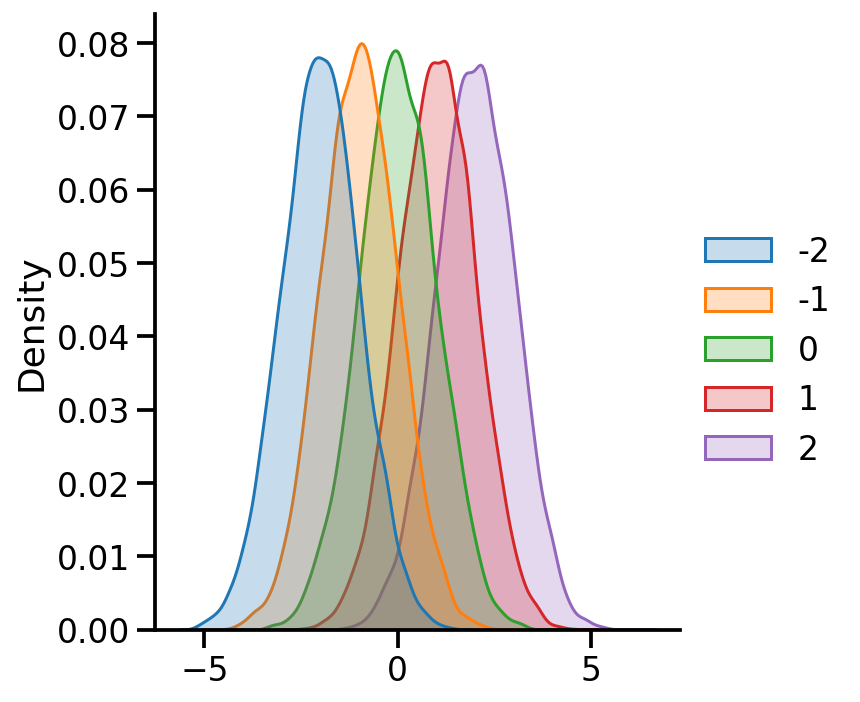

In [62]:
sns.displot(uv_normal_dict_mean_samples, kind='kde', fill=True)

In [70]:
uv_normal_dict_var = {x: tfd.Normal(loc=0, scale=x) for x in [1, 2, 5, 10]}
uv_normal_dict_var_samples = pd.DataFrame({x:uv_normal_dict_var[x].sample(10000).numpy() 
                                            for x in uv_normal_dict_var})

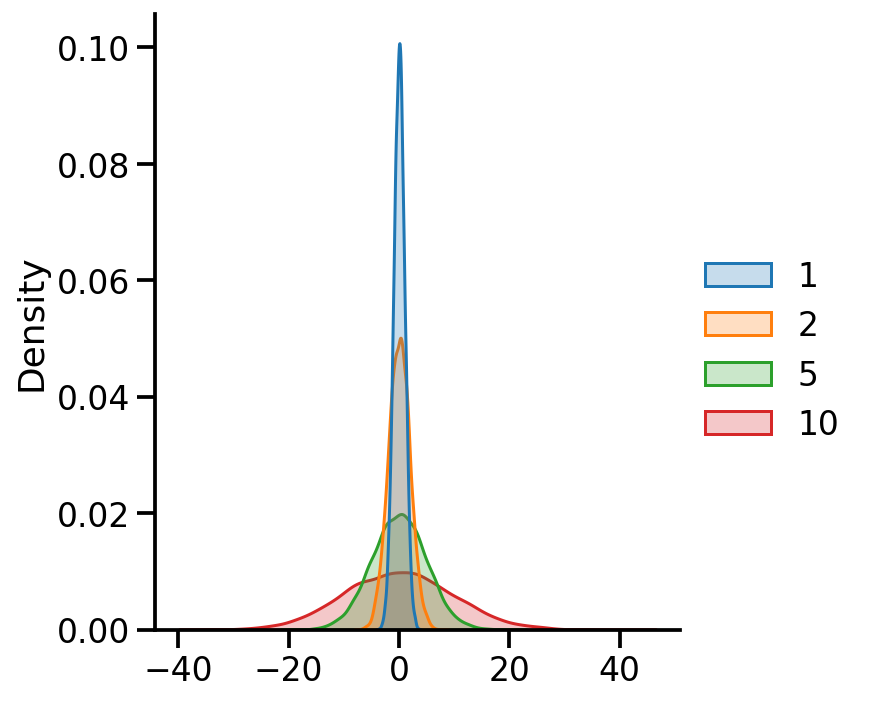

In [71]:
sns.displot(uv_normal_dict_var_samples, kind='kde', fill=True)

#### Using batches 

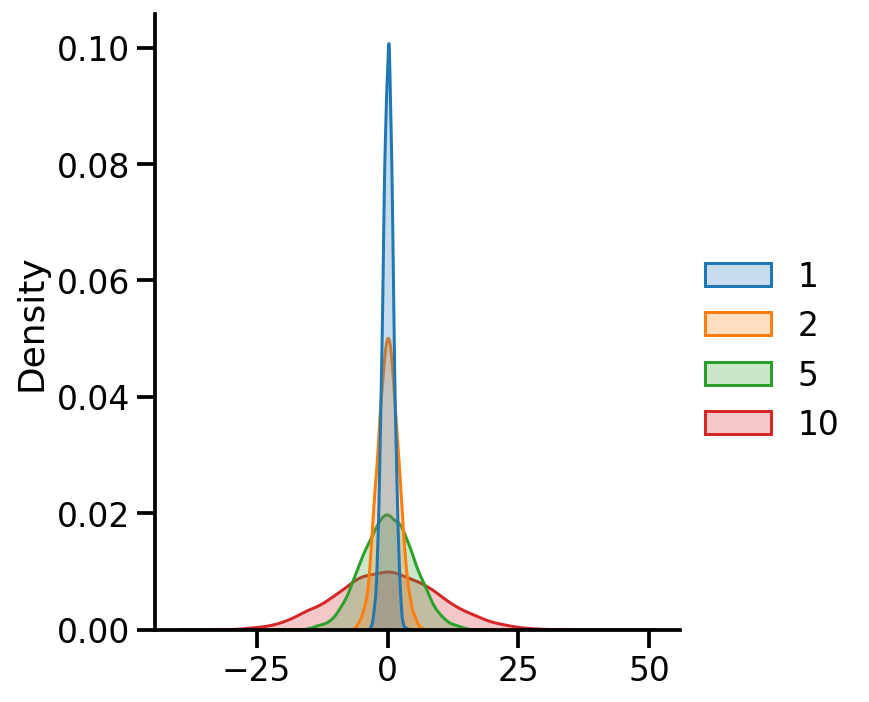

In [101]:
var_dfs = pd.DataFrame(
    tfd.Normal(loc=[0., 0., 0., 0.],
               scale=[1., 2., 5., 10.]).sample(10000).numpy())
var_dfs.columns = [1, 2, 5, 10]
sns.displot(var_dfs, kind='kde', fill=True)


In [103]:
tfd.Normal(loc=[0., 0., 0., 0.],
               scale=[1., 2., 5., 10.])

<tfp.distributions.Normal 'Normal' batch_shape=[4] event_shape=[] dtype=float32>

Text(0.5, 1.0, 'Density at x = 0.5 is 0.35\n Logprob at x = 0.5 is -1.04')

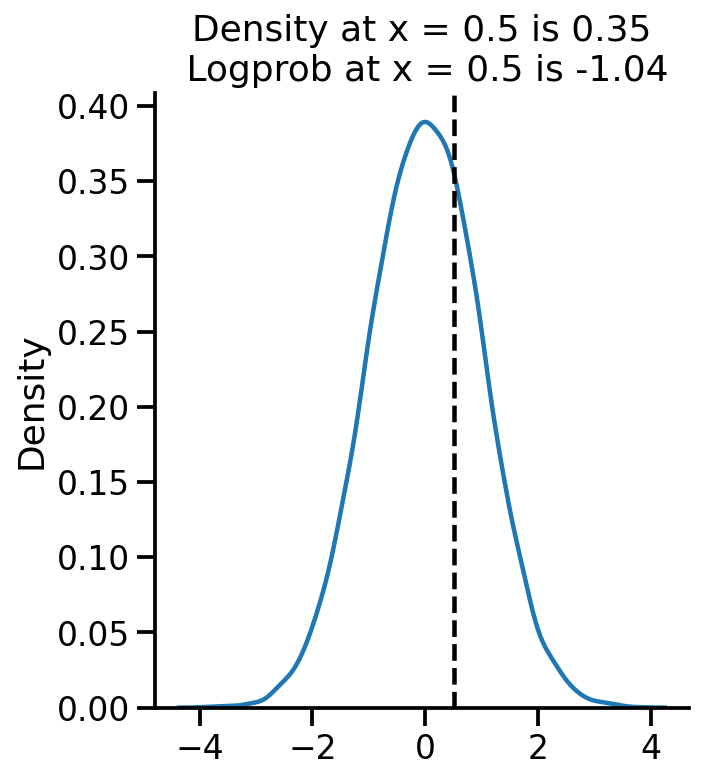

In [83]:
samples = uv_normal.sample(10000)
sns.displot(samples.numpy(), kind='kde')
plt.axvline(0.5, color='k', linestyle='--')
pdf_05 = uv_normal.prob(0.5).numpy()
log_pdf_05 = uv_normal.log_prob(0.5).numpy()


plt.title("Density at x = 0.5 is {:.2f}\n Logprob at x = 0.5 is {:.2f}".format(pdf_05, log_pdf_05))

#### Learning parameters

Let us generate some normally distributed data and see if we can `learn` the mean.

In [292]:
train_data = uv_normal.sample(10000)

In [293]:
uv_normal.loc, uv_normal.scale

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

Let us create a new TFP trainable distribution where we wish to learn the mean.

In [294]:
to_train = tfd.Normal(loc = tf.Variable(-1., name='loc'), scale = 1.)

In [295]:
to_train

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [296]:
to_train.trainable_variables

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=-1.0>,)

In [297]:
tf.reduce_mean(train_data), tf.math.reduce_variance(train_data)

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.024403999>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9995617>)

In [298]:
def nll(train):
    return -tf.reduce_mean(to_train.log_prob(train))

In [299]:
nll(train_data)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8946133>

In [300]:
def get_loss_and_grads(train):
    with tf.GradientTape() as tape:
        tape.watch(to_train.trainable_variables)
        loss = nll(train)
    grads = tape.gradient(loss, to_train.trainable_variables)
    return loss, grads

In [301]:
get_loss_and_grads(train_data)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.8946133>,
 (<tf.Tensor: shape=(), dtype=float32, numpy=-0.97559595>,))

In [302]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [303]:
optimizer

In [304]:
iterations = 500
losses = np.empty(iterations)
vals = np.empty(iterations)
for i in range(iterations):
    loss, grads = get_loss_and_grads(train_data)
    losses[i] = loss
    vals[i] = to_train.trainable_variables[0].numpy()
    optimizer.apply_gradients(zip(grads, to_train.trainable_variables))
    if i%50 == 0:
        print(i, loss.numpy())

0 1.8946133
50 1.5505791
100 1.4401271
150 1.4205703
200 1.4187955
250 1.4187206
300 1.4187194
350 1.4187193
400 1.4187193
450 1.4187194


Text(0, 0.5, 'Loss')

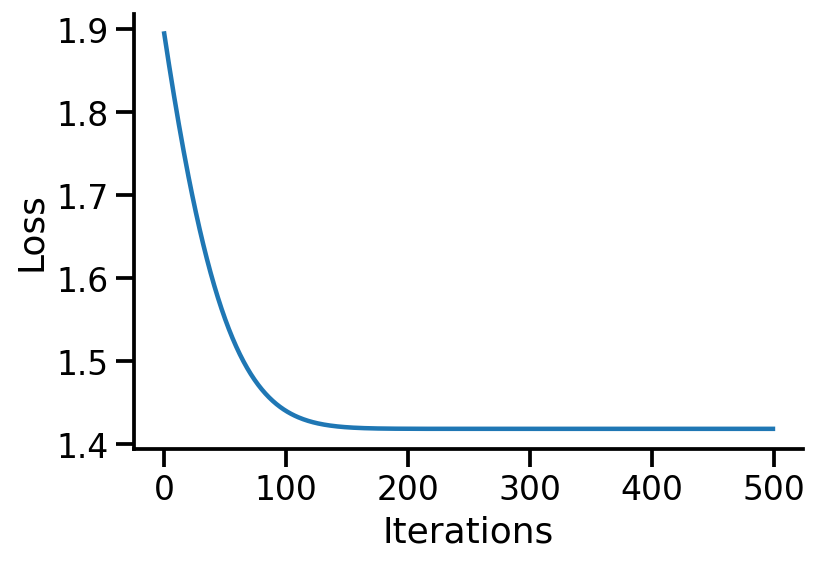

In [305]:
plt.plot(losses)
sns.despine()
plt.xlabel("Iterations")
plt.ylabel("Loss")

Text(0, 0.5, 'Value of $\\hat{\\mu}$')

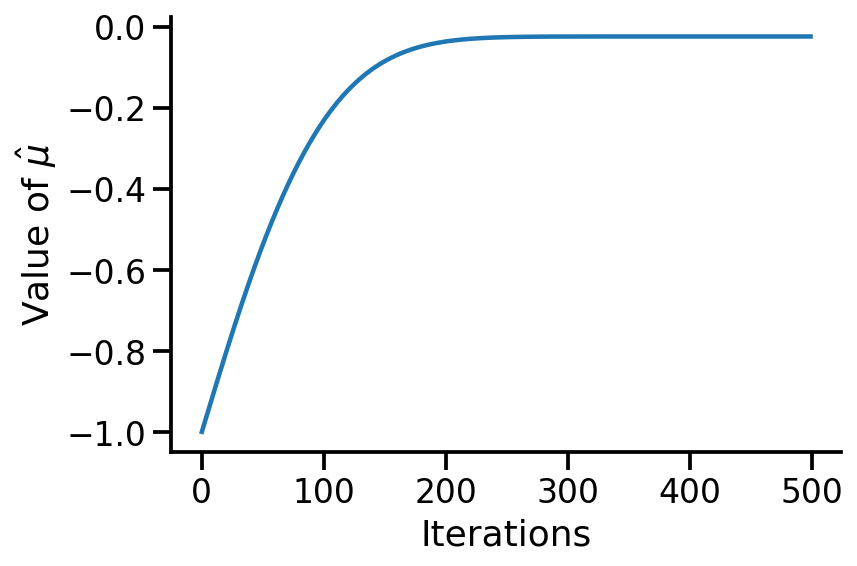

In [308]:
plt.plot(vals)
sns.despine()
plt.xlabel("Iterations")
plt.ylabel(r"Value of $\hat{\mu}$")

In [313]:
to_train_mean_var = tfd.Normal(loc = tf.Variable(-1., name='loc'), scale = tf.Variable(10., name='scale'))

def nll(train):
    return -tf.reduce_mean(to_train_mean_var.log_prob(train))

def get_loss_and_grads(train):
    with tf.GradientTape() as tape:
        tape.watch(to_train_mean_var.trainable_variables)
        loss = nll(train)
    grads = tape.gradient(loss, to_train_mean_var.trainable_variables)
    return loss, grads

to_train_mean_var.trainable_variables

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

iterations = 1000
losses = np.empty(iterations)
vals_scale = np.empty(iterations)
vals_means = np.empty(iterations)
for i in range(iterations):
    loss, grads = get_loss_and_grads(train_data)
    losses[i] = loss
    vals_means[i] = to_train_mean_var.trainable_variables[0].numpy()
    vals_scale[i] = to_train_mean_var.trainable_variables[1].numpy()


    optimizer.apply_gradients(zip(grads, to_train_mean_var.trainable_variables))
    if i%50 == 0:
        print(i, loss.numpy())

0 3.2312806
50 3.1768403
100 3.1204312
150 3.0602157
200 2.9945102
250 2.9219644
300 2.8410006
350 2.749461
400 2.6442661
450 2.5208094
500 2.3718355
550 2.1852348
600 1.9403238
650 1.6161448
700 1.4188237
750 1.4187355
800 1.4187193
850 1.4187193
900 1.4187193
950 1.4187193


Text(0, 0.5, 'Loss')

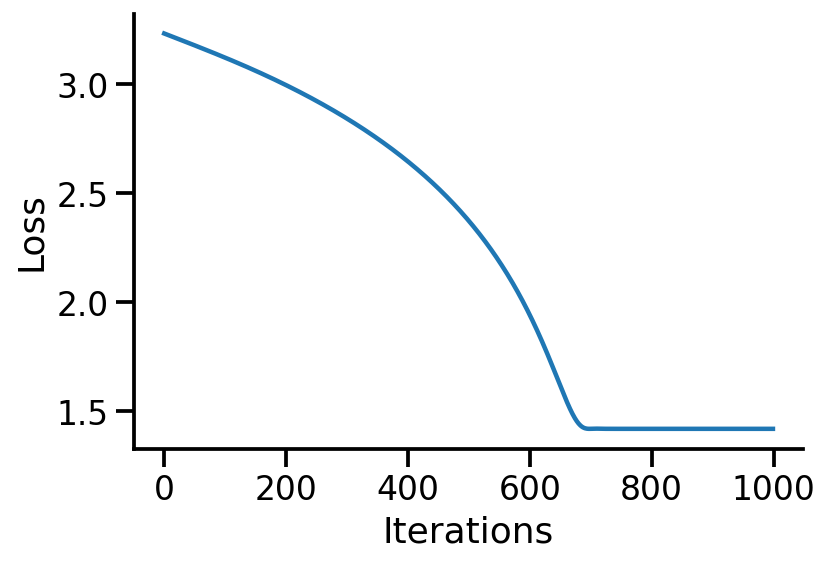

In [314]:
plt.plot(losses)
sns.despine()
plt.xlabel("Iterations")
plt.ylabel("Loss")

In [321]:
df = pd.DataFrame({"Mean":vals_means, "Scale":vals_scale}, index=range(iterations))
df.index.name = 'Iteration'

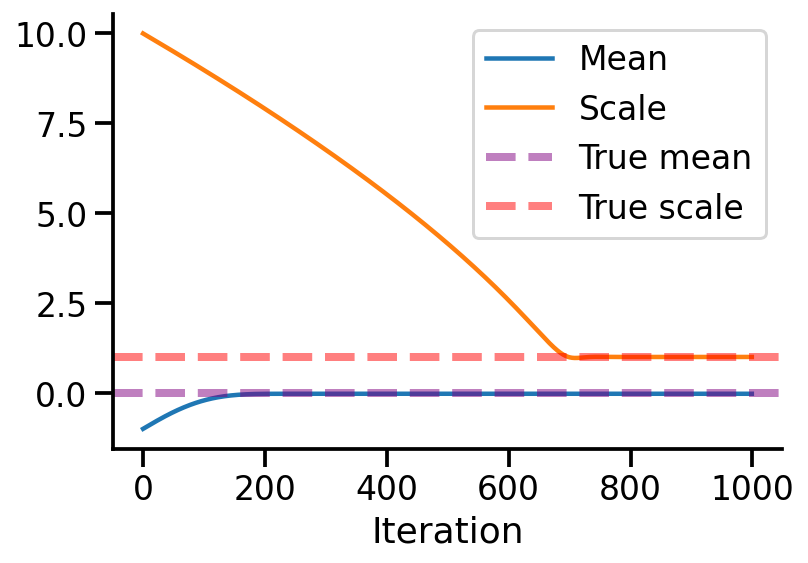

In [347]:
df.plot(alpha=1)
sns.despine()
plt.axhline(0, linestyle='--', lw = 4, label = 'True mean', alpha=0.5, color='purple')
plt.axhline(1, linestyle='--', lw = 4, label = 'True scale', alpha=0.5, color='red')
plt.legend()

#### Multivariate Normal

In [209]:
mv_normal = tfd.MultivariateNormalFullCovariance(loc=[0, 0], covariance_matrix=[[1, 0.5], [0.5, 2]])

In [210]:
mv_data = pd.DataFrame(mv_normal.sample(10000).numpy())
mv_data.columns = [r'$x_1$', r'$x_2$']


In [211]:
mv_normal.prob([0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.120309845>

In [201]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def make_pdf_2d_gaussian(mu, sigma):
    N = 60
    X = np.linspace(-3, 3, N)
    Y = np.linspace(-3, 4, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = tfd.MultivariateNormalFullCovariance(loc=mu, covariance_matrix=sigma)
    Z = F.prob(pos)

    plt.contourf(X, Y, Z, cmap=cm.Purples)
    sns.despine() 
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.gca().set_aspect('equal')
    plt.title(f'$\mu$ = {mu}\n $\Sigma$ = {np.array(sigma)}')

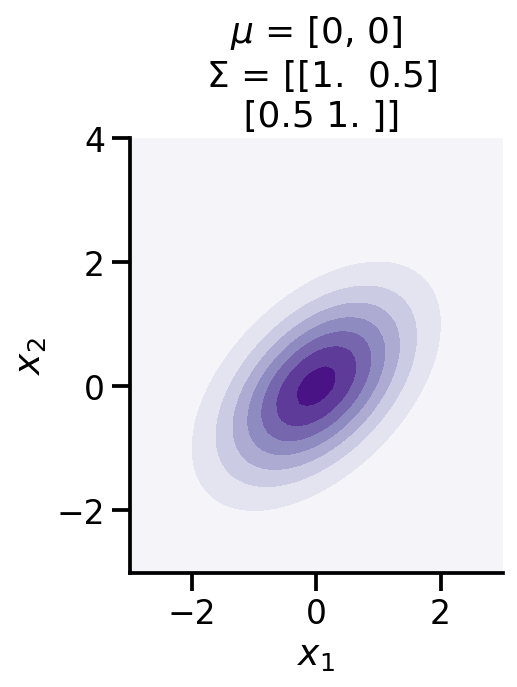

In [202]:
make_pdf_2d_gaussian([0, 0,], [[1, 0.5,], [0.5, 1]])

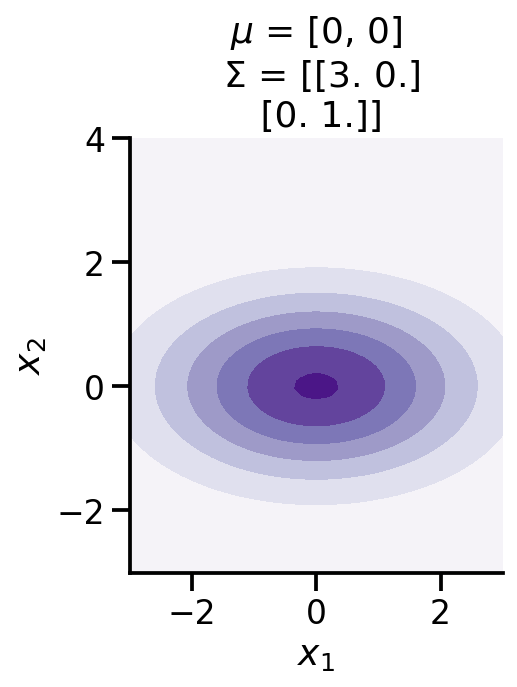

In [203]:
make_pdf_2d_gaussian([0, 0,], [[3, 0.,], [0., 1]])

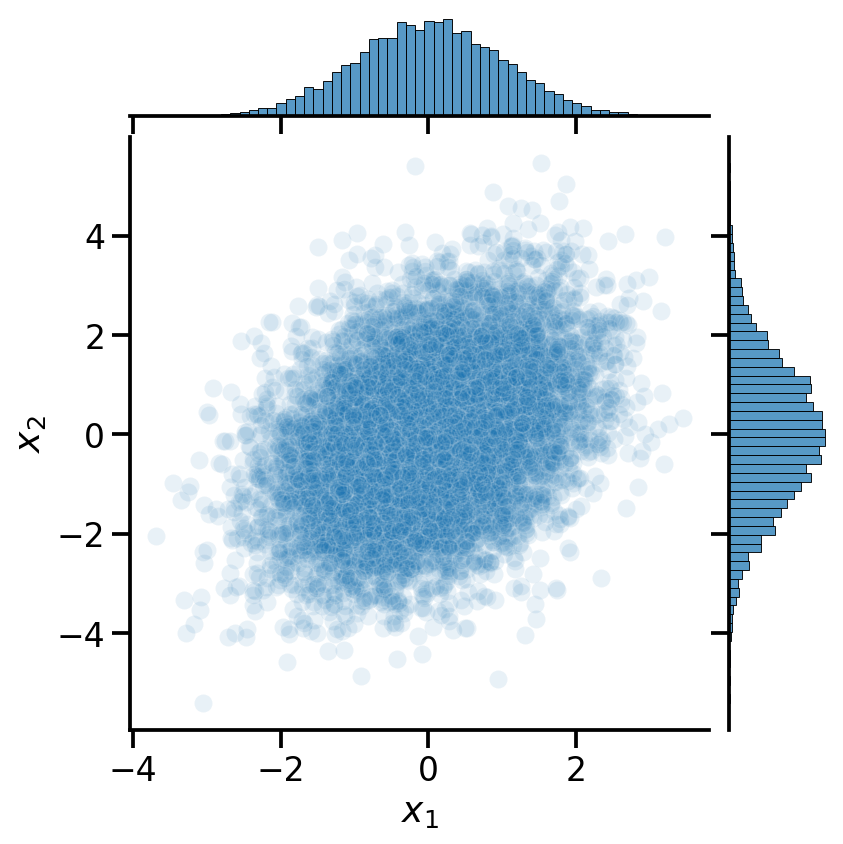

In [217]:
sns.jointplot(data=mv_data,
              x=r'$x_1$',y=r'$x_2$',
              alpha=0.1)

In [212]:
mv_data

,$x_1$,$x_2$
0,2.155621,-0.343866
1,-0.731184,0.378393
2,0.832593,-0.459740
3,-0.701200,-0.249675
4,-0.430790,-1.694002
...,...,...
9995,-0.165910,-0.171243
9996,0.208389,-1.698432
9997,-0.030418,0.353905
9998,1.342328,1.127457
